In [1]:
from rdkit import Chem, rdBase
from rdkit.Chem import rdDepictor
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.rdmolops import Get3DDistanceMatrix
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Geometry.rdGeometry import Point2D
from IPython.display import SVG
from json import dumps
from PIL import Image
import io
import numpy as np
from collections import defaultdict

In [2]:
from lassohighlight.lassohighlight import draw_substructurematch
from lassohighlight.lassohighlight import draw_multi_matches

In [3]:
smi = 'CO[C@@H](O)C1=C(O[C@H](F)Cl)C(C#N)=C1ONNC[NH3+]'
smarts = ['CONN', 'N#CC~CO', 'C=CON', 'CONNCN']

In [4]:
r = 0.3
h_ratio = 0.5

In [5]:
color_dict = {"gray": (0.5,0.5,0.5,0.5), 
              "pink": (1,0,0.5,0.5),
              "blue": (0,0.5,1,0.5), 
              "orange": (1,0.5,0,0),
              "salmon": (1,0.75,0.75,0)}

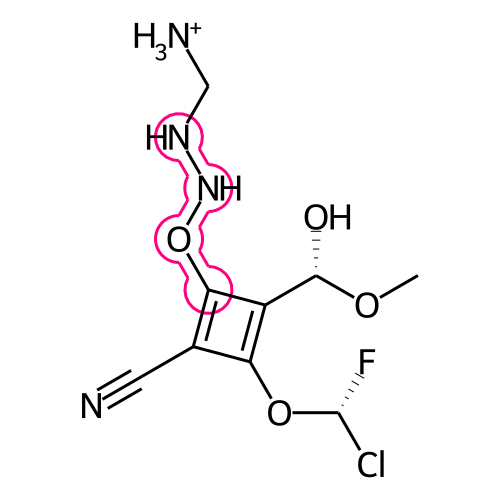

In [6]:
rdDepictor.SetPreferCoordGen(True)
mol = Chem.MolFromSmiles(smi)
mol = Draw.PrepareMolForDrawing(mol)
smart_obj = Chem.MolFromSmarts(smarts[0])
matched_atoms = set.union(*[set(x) for x in mol.GetSubstructMatches(smart_obj)])

# Defining the canvas settings
d = rdMolDraw2D.MolDraw2DCairo(500, 500)
#d.drawOptions().fillHighlights = False
#d.drawOptions().addAtomIndices = False
d.drawOptions().clearBackground = False # Leave previours drawing when a new mol is drawn
d.drawOptions().updateAtomPalette({i: (0, 0, 0, 0) for i in range(100)}) # Setting atom color to black
d.drawOptions().FillPolys= False
d.SetLineWidth(3)

# Setting up the coordinate system by drawing and erasing molecule
d.DrawMolecule(mol)
d.ClearDrawing()

# adding the lasso highlighting
draw_substructurematch(d, mol, matched_atoms, atom_radius=0.4, bond_radius_ratio=0.5, color=color_dict["pink"])

# adding the molecule
d.DrawMolecule(mol)
d.FinishDrawing()

# displaying the canvas
Image.open(io.BytesIO(d.GetDrawingText()))

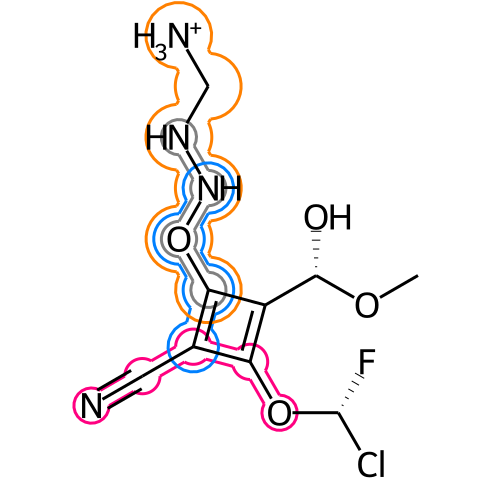

In [7]:
rdDepictor.SetPreferCoordGen(True)
mol = Chem.MolFromSmiles(smi)
mol = Draw.PrepareMolForDrawing(mol)
smart_obj_list = [Chem.MolFromSmarts(smrt) for smrt in smarts]
matched_atoms_list = [set(mol.GetSubstructMatch(smart_obj)) for smart_obj in smart_obj_list]
# Defining the canvas settings
d = rdMolDraw2D.MolDraw2DCairo(500, 500)
#d.drawOptions().fillHighlights = False
#d.drawOptions().addAtomIndices = False
d.drawOptions().clearBackground = False # Leave previours drawing when a new mol is drawn
d.drawOptions().updateAtomPalette({i: (0, 0, 0, 0) for i in range(100)}) # Setting atom color to black
d.drawOptions().FillPolys= False
d.SetLineWidth(3)

# Setting up the coordinate system by drawing and erasing molecule
d.DrawMolecule(mol)
d.ClearDrawing()

# adding the lasso highlighting
draw_multi_matches(d, mol, matched_atoms_list, bond_radius_ratio=0.5, color_list=color_dict.values())

# adding the molecule
d.DrawMolecule(mol)
d.FinishDrawing()

# displaying the canvas
Image.open(io.BytesIO(d.GetDrawingText()))

# Visualizing cBits

In [8]:
from matplotlib import cm
from matplotlib import colors
from compchemkit.machine_learning.fingerprints import FoldedMorganFingerprint

In [9]:
smiles_list = ["Cc1c(C)c2ccc(OCCCN(C)Cc3ccccc3)cc2oc1=O",
               "CCN(CCCCCCOc1ccc2c(C)c(C)c(=O)oc2c1)Cc1ccccc1",
               "Cc1c(C)c2ccc(OCc3ccc(CN(C)Cc4ccc(C#N)cc4)cc3)cc2oc1=O",]

In [10]:
bit_list = [656, 881, 1357, 1604, 1722]

In [11]:
morgan_r2 = FoldedMorganFingerprint()

In [12]:
mol = Chem.MolFromSmiles(smiles_list[1])
explained_fp = morgan_r2.bit2atom_mapping(mol)

In [13]:
c_bits = sorted(explained_fp.keys() & set(bit_list))

In [14]:
print(len(c_bits))

5


In [15]:
bit_count = defaultdict(lambda: 0)
predefined_colors = [colors.to_rgb(c) for c in ["tab:blue", "tab:orange", "tab:green", "darkviolet", "gray"]]

atom_set_list = []
color_list = []

for bit, color in zip(c_bits, predefined_colors):
    for atom_env in explained_fp[bit]:
        atom_set_list.append(set(atom_env.environment_atoms))
        color_list.append(color)
        for atom in atom_env.environment_atoms:
            bit_count[atom] += 1
combined_list = zip(atom_set_list, color_list)
combined_list = sorted(combined_list, key=lambda x: len(x[0]))
atom_set_list, color_list = list(zip(*combined_list))
bit_count = dict(bit_count)

In [16]:
highlight_norm = colors.Normalize(0.5, max(bit_count.values()))
highlight_map = cm.get_cmap("YlOrRd")
color_dict = {atom_idx:highlight_map(highlight_norm(max_bits)) for atom_idx, max_bits in bit_count.items()}

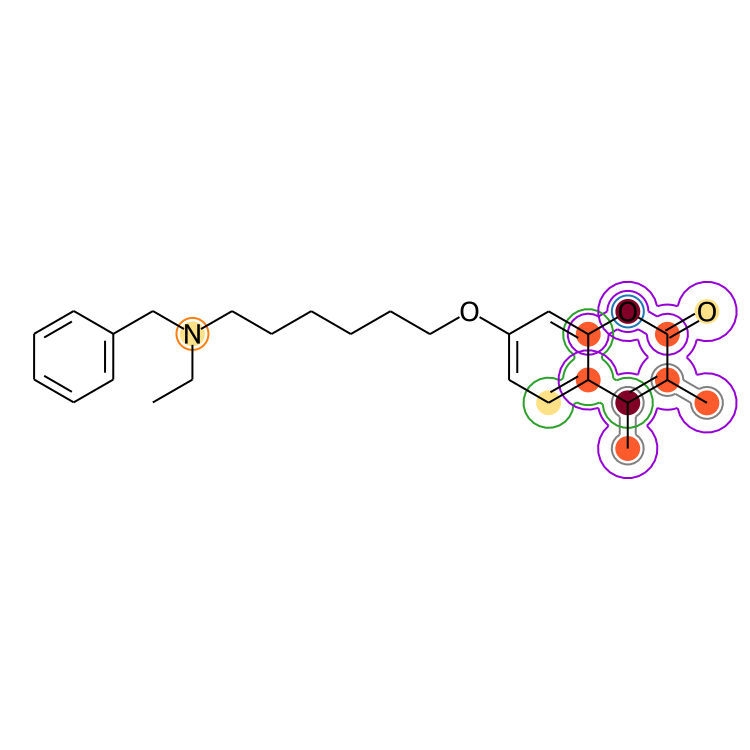

In [17]:
rdDepictor.SetPreferCoordGen(True)

d = rdMolDraw2D.MolDraw2DCairo(750, 750)
mol = Draw.PrepareMolForDrawing(mol)
conf = mol.GetConformer(0)
d.drawOptions().fillHighlights = False
d.drawOptions().addAtomIndices = False
d.drawOptions().clearBackground = False # Leave previours drawing when a new mol is drawn
d.drawOptions().updateAtomPalette({i: (0, 0, 0, 0) for i in range(100)}) # Setting atom color to black


# Setting up the coordinate system by drawing and erasing molecule
d.DrawMolecule(mol)
d.ClearDrawing()
d.SetLineWidth(2)

# Atom background color
for atom_idx, color in color_dict.items():
    d.SetColour(color)
    atom_center = conf.GetAtomPosition(atom_idx)
    
    pos = np.array([atom_center.x, atom_center.y])
    background_radius = 0.25
    edges_array = np.array([1,1]) * background_radius
    p1 = tuple(pos - edges_array)
    p2 = tuple(pos + edges_array)
    d.DrawEllipse(Point2D(*p1), Point2D(*p2))

d.SetLineWidth(2)
d.SetFillPolys(True)
conf = mol.GetConformer(0)

draw_multi_matches(d, mol, atom_set_list, bond_radius_ratio=0.5, color_list=color_list, r_min=0.35, r_dist=0.1)

d.DrawMolecule(mol)
d.FinishDrawing()

display(Image.open(io.BytesIO(d.GetDrawingText())))